#### 基于DIPY从b0图像上抽取大脑信息和掩码

In [16]:
import platform
import dipy as dp
import numpy as np
import matplotlib.pyplot as plt
from dipy.data import get_fnames
from dipy.io.image import load_nifti,save_nifti
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq

print("DIPY VERSION:",dp.__version__)
print("PYTHON VERSION:",platform.python_version())

DIPY VERSION: 1.5.0
PYTHON VERSION: 3.8.5


In [3]:
#### 从网上下载scil_b0数据集
##### Data comes from 1.5 Tesla Siemens MRI
data_fnames = get_fnames("scil_b0") 

  0%|          | 0/589 [00:00<?, ? MB/s]

In [5]:
data_fnames

['/Users/reallo/.dipy/datasets_multi-site_all_companies/1.5T/GE/b0.nii.gz',
 '/Users/reallo/.dipy/datasets_multi-site_all_companies/1.5T/Siemens/b0.nii.gz',
 '/Users/reallo/.dipy/datasets_multi-site_all_companies/3T/GE/b0.nii.gz',
 '/Users/reallo/.dipy/datasets_multi-site_all_companies/3T/Philips/b0.nii.gz',
 '/Users/reallo/.dipy/datasets_multi-site_all_companies/3T/Siemens/b0.nii.gz',
 '/Users/reallo/.dipy/datasets_multi-site_all_companies/Stanford/b0.nii.gz']

In [6]:
data,affine = load_nifti(data_fnames[1]) # 1.5T/Siemens/b0.nii.gz

In [8]:
data.shape

(128, 128, 65, 1)

In [10]:
affine

array([[   2.        ,    0.        ,   -0.        , -125.32531738],
       [   0.        ,    2.        ,   -0.        , -101.5       ],
       [  -0.        ,   -0.        ,    2.        ,  -63.92288971],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [13]:
data = np.squeeze(data) #(128, 128, 65, 1)--》(128, 128, 65)
print(data.shape)

(128, 128, 65)


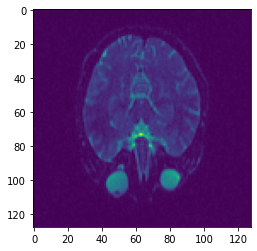

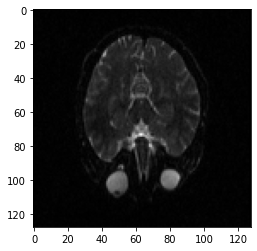

In [33]:
plt.figure()
plt.imshow(data[:,:,24].T)
plt.show()
plt.imshow(data[:,:,24].T,cmap='gray')
# 注意看下图，大脑周边存在颅骨等

#### 基于median_otsu来分割大脑数据，得到分割的大脑数据和一个二进制掩码(binary mask)
其中，还需要将图像的坐标转换成世界坐标的仿射矩阵(affine matrix)。

In [36]:
# https://dipy.org/documentation/1.5.0/reference/dipy.workflows/#median-otsu
# Simple brain extraction tool method for images from DWI data.
# an automatic histogram Otsu thresholding technique
b0_mask,mask = median_otsu(data,median_radius=2,numpass=1)

Text(0.5, 1.0, 'mask')

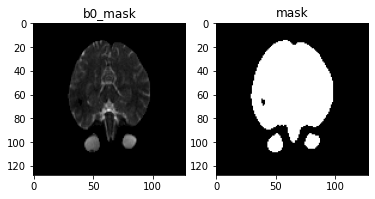

In [28]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(b0_mask[:,:,24].T,cmap='gray')
plt.title("b0_mask")

plt.subplot(1,2,2)
plt.imshow(mask[:,:,24].T,cmap='gray')
plt.title("mask")


#### 保存分割结果和二进制掩码文件

In [40]:
fname = "se_1.5t"
save_nifti(fname+'_binary_mask.nii.gz',mask.astype(np.float32),affine)
save_nifti(fname+"_mask.nii.gz",b0_mask.astype(np.float32),affine)

#### 对图像执行直方图均衡，调整图像对比度
#### https://dipy.org/documentation/1.5.0/reference/dipy.core/#histeq
Performs an histogram equalization on arr. 

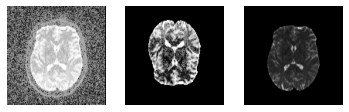

In [42]:
sli = data.shape[2] // 2
plt.figure('Brain segmentation')
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(histeq(data[:, :, sli].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(histeq(b0_mask[:, :, sli].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(b0_mask[:, :, sli].astype('float').T,
           cmap='gray', origin='lower')

# plt.savefig('median_otsu.png')

#### median_otsu还可以自动裁剪函数输出结果，以去除尽可能多的背景体素。这会使得输出的数据明显变小。median_otsu的自动裁剪功能可以通过设置自动裁剪参数（autocrop）为True来激活。

In [43]:
### median_radius,numpass参数设置越大，算法计算就会越耗时
b0_mask_autocrop,mask_autocrop = median_otsu(data,median_radius=8,numpass=8,autocrop=True)

Text(0.5, 1.0, 'mask')

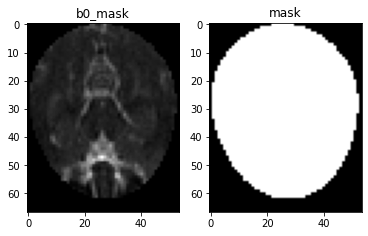

In [44]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(b0_mask_autocrop[:,:,24].T,cmap='gray')
plt.title("b0_mask")

plt.subplot(1,2,2)
plt.imshow(mask_autocrop[:,:,24].T,cmap='gray')
plt.title("mask")